<a href="https://colab.research.google.com/github/rodrigodemend/Diagnostico-de-Dados-Clinicos-com-Machine-Learning/blob/main/Notebooks/Funcoes_utilizadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagnóstico de Dados Clínicos com Machine Learning

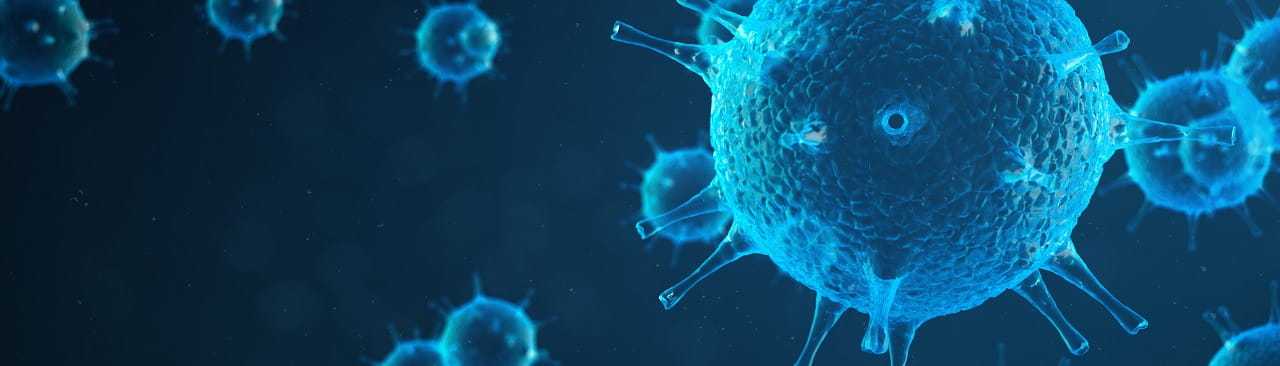

Bootcamp Data Science Alura

Autor: Rodrigo de Mendonça 

<a href="https://www.linkedin.com/in/rodrigomendonça/" alt="linkedin" target="_blank">
<img src="https://img.shields.io/badge/LinkedIn-%230077B5.svg?&style=flat-square&logo=linkedin&logoColor=white">
</a>

<a href="mailto:<rodrigodemend@gmail.com>" alt="gmail" target="_blank">
<img src="https://img.shields.io/badge/-Gmail-FF0000?style=flat-square&labelColor=FF0000&logo=gmail&logoColor=white&link=mailto:<SEUEMAIL>" />
</a>

Este é o projeto final do Bootcamp Data Science da Alura! Nele eu pude demonstrar todo o conhecimento adquirido durante o Bootcamp, aplicando em um caso real de dados disponibilizados pelo hospital Sírio-Libanês. O principal objetivo é a construção de um modelo de machine learning capaz de detectar quais pacientes do hospital Sírio-Libanês que foram internados, irão agravar seus casos e precisarão de leito de UTI.

Este notebook tem como objetivo reunir todas as funções criadas durante o desenvolvimento do projeto. 

Estou criando um notebook separado para essas funções para que o projeto fique mais limpo e organizado.

# Bibliotecas

O primeiro passo em qualquer projeto de machine learning é a importação das bibliotecas que serão utilizadas no projeto.

Nós iremos utilizar bibliotecas comumente usadas em projeto de machine learning como pandas, numpy, sklearn, matplotlib, seaborn, etc.

## Bibliotecas Utilizadas

Aqui nós temos a lista de todas as bibliotecas utilizadas nesse projeto e suas respectivas versões:


*   pandas (V.1.1.5)
*   numpy (V.1.19.5)
*   matplotlib (V.3.2.2)
*   seaborn (V.0.11.2)
*   sklearn (V.1.0.2)
*   imblearn (V.0.8.1)
*   feature_engine (V.1.2.0)
*   mlxtend (V.0.14.0)
*   skopt (V.0.9.0)
*   joblib (V.1.1.0)

## Bibliotecas que não vem por padrão no Google Colab

Aqui nós temos algumas instalações de bibliotecas que não vem por padrão no Google Colab.

In [ ]:
# feature_engine
!pip install feature_engine

# scikit-optimize
!pip install scikit-optimize

# mlxtend
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

## Importação das Biblitecas

Como forma de organização, separamos a importação das bibliotecas comentando para qual finalidade estamos importando aquela biblioteca.

In [ ]:
# Manipulação dos Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Mapeamento de variáveis categóricas
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Pré processamento dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler
from imblearn.over_sampling import SMOTENC

# Seleção de Variáveis
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import SmartCorrelatedSelection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Validação 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

# Métricas
from sklearn.metrics import roc_auc_score

# Otimização de Hiperparâmetros
from skopt.plots import plot_convergence
from skopt import gp_minimize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Salvando os modelos
from joblib import dump, load

# Warnings
import warnings
warnings.filterwarnings('ignore')


# Funções Desenvolvidas

Todas as funções foram agrupadas para facilitar a consulta, como por exemplo, todas as funções referentes a seleção de atributos estão reunidas na mesma seção.

## Tratamento de Valores Faltantes

Nessa subseção temos todas as bibliotecas desenvolvidas referente ao tratamento de valores faltantes.

In [ ]:
def removendo_pacientes_com_vazamento_de_dados(dados):
  # Criando um set que irá servir para selecionar os pacientes para remover
  pacientes_para_remover = set()

  # Rodando um for para cada paciente
  for paciente, dados_do_paciente in dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False):
    
    # Rodando um for para cada coluna 
    # Aqui vamos achar os pacientes onde o primeiro valor válido naquela coluna já estão na ICU
    # e para que não tenha vazamento de dados, iremos adicionar o paciente no set para removê-los
    for coluna in dados_do_paciente.columns:

      # Pulando a coluna ICU pois não queremos analisa-la
      if coluna != 'ICU':

        # Selecionando apenas a coluna que estamos analisando e a coluna ICU
        # dropna irá remover todas as linhas onde existem valores nulos, porém como só pode
        # existir valores nulos na coluna que estamos analisando, a primeira linha que irá retornar
        # será o primeiro valor válido daquela coluna
        dados_sem_NaN = dados_do_paciente[[coluna, 'ICU']].dropna().reset_index(drop=True)
        
        # Caso exista algum valor válido para a coluna, irá entrar no if
        if dados_sem_NaN.shape[0] > 0:

          # Verificando se o paciente está na ICU no primeiro valor válido para a coluna
          if dados_sem_NaN.iloc[0]['ICU'] == 1:
            
            # Adicionando o paciente para poder removê-lo
            pacientes_para_remover.add(paciente)
        
        # Caso o paciente tenha a coluna inteira nula, irá para o else
        else:
          
          # Adicionando o paciente para poder removê-lo
          pacientes_para_remover.add(paciente)

  # Retornando apenas os dados sem os pacientes que selecionamos para remover
  return dados[~dados['PATIENT_VISIT_IDENTIFIER'].isin(pacientes_para_remover)]

## Engenharia de Atributos

Nessa subseção temos todas as bibliotecas desenvolvidas referente a engenharia de atributos.

In [ ]:
def Ajustando_Escala(dados, features_para_ajustar_escala):

  """
  Função com o objetivo de mudar a escala das features para:
  Mínimo: -1
  Máximo: 1
  """

  # Fazendo o ajuste do scaler
  scaler = MinMaxScaler((-1, 1)).fit(dados[features_para_ajustar_escala])

  # Ajustando os dados (não retorna um DataFrame)
  dados_ajustados = scaler.transform(dados[features_para_ajustar_escala])

  # Transformando os dados ajustandos em DataFrame
  dados_ajustados = pd.DataFrame(dados_ajustados, columns=features_para_ajustar_escala)

  # Atualizando os dados
  for feature in features_para_ajustar_escala:
    dados[feature] = dados_ajustados[feature]
  
  # Retornando dados escalonados
  return dados

In [ ]:
def Ajusta_Escala_Int(dados):

  """
  Função para passar os dados inteiros de [0 1] para a escala [-1 1]
  """
  
  # Dicionário de mapeamento das features do tipo inteiro
  int_map = {
      0: -1, # Transformando os valores que são 0 em -1
      1: 1 # Mantendo os valores que são 1 como 1
  }

  # Selecionando as features que são do tipo inteiro
  features_int = list(dados.drop('ICU', axis=1).select_dtypes(include='int64').columns)

  # Fazendo o mapeamento das features
  for feature in features_int:
    dados[feature] = dados[feature].map(int_map)
  
  # Retornando dados escalonados
  return dados

## Seleção de Atributos

Nessa subseção temos todas as bibliotecas desenvolvidas referente a seleção de atributos.

In [ ]:
def Remove_Quasi_Constant_Features(dados, tol=0.99, print_results=True):

  """
  Função com objetivo de remover as features quasi contants dos dados
  """

  # Dividindo os dados em dados de previsão (x) e dados alvo (y)
  X_Dados = dados.drop(['ICU'], axis=1)
  Y_Dados = dados['ICU']

  # criando o objeto da função
  sel = DropConstantFeatures(tol=tol, variables=None, missing_values='raise')
  # tol=0.998 representa que irá remover as quasi-constant features, ou seja,
  # as que contém o mesmo valor em 99,8% todas as linhas .
  # variables=None quer dizer que vamos fazer esse teste para todas as features, porém se quisessemos poderiamos ter
  # passado apenas um grupo de variáveis.
  # missing_values='raise', poderia ser 'ignore'
  # realizando o teste e obtendo as variaveis que são quasi-constant
  sel.fit(X_Dados)

  # Removendo as Features Quase Constantes
  X_Dados = sel.transform(X_Dados)

  # Reconstruindo o DataFrame com os dados de previsão (x) e dados alvo (y)
  dados = pd.concat([X_Dados, Y_Dados], axis=1)

  if print_results:
    # Número de Features Quase Constantes
    print('Número de Features Quase Constantes:', len(sel.features_to_drop_), '\n')
    # Printando quais Features foram removidas
    print('Features que foram removidas')
    print(sel.features_to_drop_)

  return dados, len(sel.features_to_drop_)

In [ ]:
def Encontrando_Tolerancia_Features_Quasi_Cosntants(dados):

  """
  Está função tem o objetivo de criar um DataFrame para podermos escolhermos
  qual a tolerância que devemos usar na remoção das das features quasi-constants
  """

  # Declaração das listas para agrupar os resultados em um DataFrame depois
  tolerancia_lista = []
  n_features_removidas_lista = []
  auc_treino_lista = []
  auc_teste_lista = []

  # Loop para descobrir a melhor tolerância
  for i in range(1, 16):
    # Calculando a tolerância
    tolerancia = 1 - (i/100)
    # Adicionando na lista a tolerância calculada
    tolerancia_lista.append(tolerancia)
    
    # Removendo as quasi-constants features
    dados_removidos, n_features_removidas = Remove_Quasi_Constant_Features(dados, tol=tolerancia, print_results=False)
    # Adicionando na lista o número de features removidas
    n_features_removidas_lista.append(n_features_removidas)
    
    # Rodando o modelo com dados sem as features removidas
    modelo = LogisticRegression()
    auc_treino, auc_teste = roda_modelo_cv(modelo, dados_removidos, n_splits=5, n_repeats=10, smote=True, print_results=False)
    
    # Adicionando as listas os resultados do AUC de Treino e Teste
    auc_treino_lista.append(auc_treino)
    auc_teste_lista.append(auc_teste)

  # Agrupando os resultados em um DataFrame
  resultados = pd.DataFrame({'Tolerância': tolerancia_lista,
                            'N° Features Removidas': n_features_removidas_lista,
                            'AUC Treino': auc_treino_lista,
                            'AUC Teste': auc_teste_lista})
  
  # Retornando o DataFrame com os resutados
  return resultados

In [ ]:
def Remove_Duplicated_Features(dados, print_results=True):

  """
  Função com objetivo de remover as features duplicadas dos dados
  """

  # Dividindo os dados em dados de previsão (x) e dados alvo (y)
  X_Dados = dados.drop(['ICU'], axis=1)
  Y_Dados = dados['ICU']

  # criando o objeto da função
  sel = DropDuplicateFeatures(variables=None, missing_values='raise')
  # variables=None quer dizer que vamos fazer esse teste para todas as features, porém se quisessemos poderiamos ter
  # passado apenas um grupo de variáveis.
  # missing_values='raise', poderia ser 'ignore'...caso for "raise" ele vai dar um erro se tiver NaN
  # Encontrandos as features duplicadas
  sel.fit(X_Dados)

  # Removendo as Features Duplicadas
  X_Dados = sel.transform(X_Dados)

  # Reconstruindo o DataFrame com os dados de previsão (x) e dados alvo (y)
  dados = pd.concat([X_Dados, Y_Dados], axis=1)

  if print_results:
    # Número de Features Duplicadas
    print('Número de Features Duplicadas:', len(sel.features_to_drop_), '\n')
    # Printando quais Features foram removidas
    print('Features que foram removidas')
    print(sel.features_to_drop_)

  return dados, len(sel.features_to_drop_)

In [ ]:
def Remove_Correlated_Features(modelo, dados, print_results=True):

  """
  Função com objetivo de remover as features correlacionadas dos dados
  """

  # Dividindo os dados em dados de previsão (x) e dados alvo (y)
  X_Dados = dados.drop(['ICU'], axis=1)
  Y_Dados = dados['ICU']

  # Seletor de Correlação
  sel = SmartCorrelatedSelection(
  variables=None, # Se none, seletor examina todas as features númericas (aqui poderia passar um grupo de features)
  method="pearson", # método de correlação
  threshold=0.8, # limiar para dizer se uma feature é correlacionada com outra
  missing_values="raise", # "raise" indica que vai dar um erro caso tenha NaN / Também poderia ser "ignore"
  selection_method="model_performance", # dizendo que queremos usar um modelo como seletor
  estimator=modelo, # instancia do modelo que será utilizado como arbritório
  scoring="roc_auc", # métrica que será vista pelo modelo
  cv=5, # dizendo que é para usar crossvalidation
  )

  # Basicamente ele irá decidir por 1 feature dentro do grupo, onde irá criar uma regressão logística
  # para cada feature (com apenas essa feature como preditora), e então irá selecionar a que teve melhor métrica que foi passada.
  sel.fit(X_Dados, Y_Dados)

  # Removendo as Features Correlacionadas
  X_Dados = sel.transform(X_Dados)

  # Reconstruindo o DataFrame com os dados de previsão (x) e dados alvo (y)
  dados = pd.concat([X_Dados, Y_Dados], axis=1)

  if print_results:
    # Número de Features Correlacionadas
    print('Número de Features Correlacionadas:', len(sel.features_to_drop_), '\n')
    # Printando quais Features foram removidas
    print('Features que foram removidas')
    print(sel.features_to_drop_)

  return dados, len(sel.features_to_drop_)

In [ ]:
def Step_Backward_Selection(modelo, dados, k_features, smote=False, smote_print=False):

  # Dividindo os dados em dados de previsão (x) e dados alvo (y)
  X_Dados = dados.drop(['ICU'], axis=1)
  Y_Dados = dados['ICU']

  # SMOTE - Balanceando as classes
  if smote:
    
    # Visualizando contagem antes do smote
    if smote_print:
      print('Contagem de Classes Antes do SMOTE')
      print(Y_Dados.value_counts(), '\n')

    # Selecionando as features categóricas (que são as int64 nesse caso)
    categorical_features = [True if X_Dados[coluna].dtypes == 'int64' else False for coluna in X_Dados.columns]
    # Instânciando o SMOTE
    sm = SMOTENC(categorical_features)
    # Realizando o Balanceamento
    X_Dados, Y_Dados = sm.fit_resample(X_Dados, Y_Dados)

    # Visualizando contagem após o smote
    if smote_print:
      print('Contagem de Classes Depois do SMOTE')
      print(Y_Dados.value_counts(), '\n')

  sfs = SFS(modelo, # Definindo o algoritimo de machine learning
  k_features=k_features, # A quantidade de features que queremos que seja o ponto de parada
  forward=False, # Nós estamos querendo o Backward method
  floating=False, 
  verbose=2, # indica o número de prints para acompanhar o resultado
  scoring='roc_auc', # métrica de avaliação
  cv=2) #crossvalidation

  # Realizando a seleção
  sfs = sfs.fit(np.array(X_Dados), Y_Dados) 

  # Retornando a seleção
  return sfs

In [ ]:
def Achando_Melhores_Resultados_Step_Backward_Selection(df_sfs, dados, modelo):
  # Listas para salvar os resultados em um dataframe
  lista_index = []
  lista_auc_treino = []
  lista_auc_teste = []

  for i in range(df_sfs.shape[0]):
    # Escolhendo o index do dataframe anterior
    index_escolhido = i

    # Transformando o index em uma lista
    import ast
    index_list = list(ast.literal_eval(df_sfs.loc[index_escolhido, 'feature_idx']))
    #index_list = list(df_sfs.loc[index_escolhido, 'feature_idx'])

    # Pegando uma lista com as features (colunas) selecionadas / feature_idx retorna um array com os index das colunas
    features_selecionadas = dados.drop(['ICU'], axis=1).columns[index_list]

    # Transformando em lista
    features_selecionadas = [i for i in features_selecionadas]
    # Adicionando variável target
    features_selecionadas.append('ICU')

    # Visualizando resultados em tempo de execução
    print('index:', i)
    auc_treino, auc_teste = roda_modelo_cv(modelo, dados[features_selecionadas], n_splits=5, n_repeats=10, smote=True)
    print()

    # Salvando resultados
    lista_index.append(i)
    lista_auc_treino.append(auc_treino)
    lista_auc_teste.append(auc_teste)


  # Dataframe resultante
  df_resultados_index = pd.DataFrame({
      'Index':lista_index,
      'AUC Treino':lista_auc_treino,
      'AUC Teste':lista_auc_teste
  })

  return df_resultados_index

## Treinamento e Teste do Modelo

Nessa subseção temos todas as bibliotecas desenvolvidas referente ao treinamento e teste dos modelos de machine learning.

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats, print_results=True, smote=False, smote_print=False):

    # Definindo uma seed para conseguir reproduzir os mesmo resultados
    np.random.seed(1231234)

    # Embaralhando os dados antes do crossvalidation, pois o RepeatedStratifiedKFold não tem o parâmetro suffle
    dados = dados.sample(frac=1).reset_index(drop=True)

    # Separando os dados preditores (x) dos dados alvo (y)
    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)

    # SMOTE - Balanceando as classes
    if smote:
      
      # Visualizando contagem antes do smote
      if smote_print:
        print('Contagem de Classes Antes do SMOTE')
        print(y.value_counts(), '\n')

      # Selecionando as features categóricas (que são as int64 nesse caso)
      categorical_features = [True if x[coluna].dtypes == 'int64' else False for coluna in x.columns]
      # Instânciando o SMOTE
      sm = SMOTENC(categorical_features)
      # Realizando o Balanceamento
      x, y = sm.fit_resample(x, y)

      # Visualizando contagem após o smote
      if smote_print:
        print('Contagem de Classes Depois do SMOTE')
        print(y.value_counts(), '\n')

    # RepeatedStratifiedKFold faz a mesma coisa que o StratifiedKFold, porém
    # ele repete esses mesmos testes do crossvalidate n vezes
    cv = RepeatedStratifiedKFold(n_splits = n_splits, # Número de repartições (recomendado entre 5-10)
                                 n_repeats=n_repeats) # Número de repetições do processo de crossvalidation
    
    # Realizando o crossvalidation
    resultados=cross_validate(modelo, # Estimador - Instância do modelo que iremos treinar
                              x, # Dados Preditores (lembre que aqui não podemos dividir em treino e teste previamente)
                              y, # Dados Alvo (lembre que aqui não podemos dividir em treino e teste previamente)
                              cv=cv, # Número de repartições que iremos fazer
                              scoring='roc_auc', # Métrica de avaliação do modelo 
                              return_train_score=True) # Retornando a perfomace do modelo nos dados de treino
    # Test Score seria o resultado da métrica que estamos querendo ver a performace

    # Calculando a média e o desvio padrão para o calculo do intervalo de confiança dos dados de treino
    auc_medio_treino = np.mean(resultados['train_score'])
    auc_std_treino = np.std(resultados['train_score'])
    
    # Calculando a média e o desvio padrão para o calculo do intervalo de confiança dos dados de teste
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
    if print_results:
      # Printando o AUC médio e o intervalo de confiança para os dados de treino
      print('Resultados Alcançados')
      print(f"AUC Médio de Treino: {auc_medio_treino} - Intervalo: {auc_medio_treino - (2*auc_std_treino)} - {auc_medio_treino + (2*auc_std_treino)}")
      
      # Printando o AUC médio e o intervalo de confiança para os dados de teste
      print(f"AUC Médio de Teste: {auc_medio} - Intervalo: {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

    # Retornando o auc médio de treino e teste
    return auc_medio_treino, auc_medio
    

## Otimização de Hiperparâmetros

Nessa subseção temos todas as bibliotecas desenvolvidas referente a otimização de hiperparâmetros.

In [ ]:
def roda_modelo_GridSearchCV(modelo, dados, n_splits, n_repeats, espaco_de_parametros, print_results=True, smote=False, smote_print=False):

    # Definindo uma seed para conseguir reproduzir os mesmo resultados
    np.random.seed(1231234)

    # Embaralhando os dados antes do crossvalidation, pois o RepeatedStratifiedKFold não tem o parâmetro suffle
    dados = dados.sample(frac=1).reset_index(drop=True)

    # Separando os dados preditores (x) dos dados alvo (y)
    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)

    # SMOTE - Balanceando as classes
    if smote:
      
      # Visualizando contagem antes do smote
      if smote_print:
        print('Contagem de Classes Antes do SMOTE')
        print(y.value_counts(), '\n')

      # Selecionando as features categóricas (que são as int64 nesse caso)
      categorical_features = [True if x[coluna].dtypes == 'int64' else False for coluna in x.columns]
      # Instânciando o SMOTE
      sm = SMOTENC(categorical_features)
      # Realizando o Balanceamento
      x, y = sm.fit_resample(x, y)

      # Visualizando contagem após o smote
      if smote_print:
        print('Contagem de Classes Depois do SMOTE')
        print(y.value_counts(), '\n')

    # RepeatedStratifiedKFold faz a mesma coisa que o StratifiedKFold, porém
    # ele repete esses mesmos testes do crossvalidate n vezes
    cv = RepeatedStratifiedKFold(n_splits = n_splits, # Número de repartições (recomendado entre 5-10)
                                 n_repeats=n_repeats) # Número de repetições do processo de crossvalidation
    
    # Criando o GridSearchCV
    busca = GridSearchCV(modelo, # Estimador - Instância do modelo que iremos treinar
                         param_grid=espaco_de_parametros, # Espaço de parâmetros para busca
                         cv = cv, # Número de repartições que iremos fazer
                         scoring='roc_auc', # Métrica de avaliação do modelo
                         return_train_score=True) # Retornando a perfomace do modelo nos dados de treino
    
    # Realizando a busca
    busca.fit(x, y)

    # Criando um dataframe com os resultados
    resultados = pd.DataFrame(busca.cv_results_)

    # Calculando a média e o desvio padrão para o calculo do intervalo de confiança dos dados de treino
    auc_medio_treino = resultados.iloc[busca.best_index_]['mean_train_score']
    auc_std_treino = resultados.iloc[busca.best_index_]['std_train_score']

    # Calculando a média e o desvio padrão para o calculo do intervalo de confiança dos dados de teste
    auc_medio = resultados.iloc[busca.best_index_]['mean_test_score']
    auc_std = resultados.iloc[busca.best_index_]['std_test_score']

    if print_results:
      # Printando o AUC médio e o intervalo de confiança para os dados de treino
      print('Resultados Alcançados')
      print(f"AUC Médio de Treino: {auc_medio_treino} - Intervalo: {auc_medio_treino - (2*auc_std_treino)} - {auc_medio_treino + (2*auc_std_treino)}")
      
      # Printando o AUC médio e o intervalo de confiança para os dados de teste
      print(f"AUC Médio de Teste: {auc_medio} - Intervalo: {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

    # Retornando o auc médio de treino e teste
    return auc_medio_treino , auc_medio, resultados, busca.best_index_

In [ ]:
def roda_modelo_RandomizedSearchCV(modelo, dados, n_splits, n_repeats, espaco_de_parametros, n_iter, print_results=True, smote=False, smote_print=False):

    # Definindo uma seed para conseguir reproduzir os mesmo resultados
    np.random.seed(1231234)

    # Embaralhando os dados antes do crossvalidation, pois o RepeatedStratifiedKFold não tem o parâmetro suffle
    dados = dados.sample(frac=1).reset_index(drop=True)

    # Separando os dados preditores (x) dos dados alvo (y)
    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)

    # SMOTE - Balanceando as classes
    if smote:
      
      # Visualizando contagem antes do smote
      if smote_print:
        print('Contagem de Classes Antes do SMOTE')
        print(y.value_counts(), '\n')

      # Selecionando as features categóricas (que são as int64 nesse caso)
      categorical_features = [True if x[coluna].dtypes == 'int64' else False for coluna in x.columns]
      # Instânciando o SMOTE
      sm = SMOTENC(categorical_features)
      # Realizando o Balanceamento
      x, y = sm.fit_resample(x, y)

      # Visualizando contagem após o smote
      if smote_print:
        print('Contagem de Classes Depois do SMOTE')
        print(y.value_counts(), '\n')

    # RepeatedStratifiedKFold faz a mesma coisa que o StratifiedKFold, porém
    # ele repete esses mesmos testes do crossvalidate n vezes
    cv = RepeatedStratifiedKFold(n_splits = n_splits, # Número de repartições (recomendado entre 5-10)
                                 n_repeats=n_repeats) # Número de repetições do processo de crossvalidation
    
    # Criando o RandomizedSearchCV
    busca = RandomizedSearchCV(modelo, # Estimador - Instância do modelo que iremos treinar
                                param_distributions=espaco_de_parametros, # Espaço de parâmetros para busca
                                n_iter = n_iter, # Número de iterações que ele vai buscar aleatóriamente
                                cv = cv, # Número de repartições que iremos fazer
                                scoring='roc_auc', # Métrica de avaliação do modelo
                                return_train_score=True) # Retornando a perfomace do modelo nos dados de treino
    
    # Realizando a busca
    busca.fit(x, y)

    # Criando um dataframe com os resultados
    resultados = pd.DataFrame(busca.cv_results_)

    # Calculando a média e o desvio padrão para o calculo do intervalo de confiança dos dados de treino
    auc_medio_treino = resultados.iloc[busca.best_index_]['mean_train_score']
    auc_std_treino = resultados.iloc[busca.best_index_]['std_train_score']

    # Calculando a média e o desvio padrão para o calculo do intervalo de confiança dos dados de teste
    auc_medio = resultados.iloc[busca.best_index_]['mean_test_score']
    auc_std = resultados.iloc[busca.best_index_]['std_test_score']

    if print_results:
      # Printando o AUC médio e o intervalo de confiança para os dados de treino
      print('Resultados Alcançados')
      print(f"AUC Médio de Treino: {auc_medio_treino} - Intervalo: {auc_medio_treino - (2*auc_std_treino)} - {auc_medio_treino + (2*auc_std_treino)}")
      
      # Printando o AUC médio e o intervalo de confiança para os dados de teste
      print(f"AUC Médio de Teste: {auc_medio} - Intervalo: {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

    # Retornando o auc médio de treino e teste
    return auc_medio_treino , auc_medio, resultados, busca.best_index_

In [ ]:
def Otimiza_um_por_vez(dados_rf, espaco_de_parametros):  
  # Dicionárioque terá os melhores hiperparâmetros no final
  param_dict = {}

  # Loop entre todos os hiperparâmetros
  for hiper_param in espaco_de_parametros:
    # Variáveis para salvar resultados intermediários
    best_value = 0
    best_result = 0
    # Loop para buscar o melhor parâmetro
    for param in espaco_de_parametros[hiper_param]:
      # Passando o parâmetro atual para o diciónario
      param_dict[hiper_param] = param

      # Treinando a Random Forest com aqueles parâmetros
      modelo = RandomForestClassifier(**param_dict)
      auc_treino, auc_teste = roda_modelo_cv(modelo, dados_rf, n_splits=5, n_repeats=10, smote=True)

      # Verificando se o melhor resultado foi batido
      if auc_teste > best_result:
        # Salvando o melhor resultado
        best_result = auc_teste
        # Salvando o melhor parâmetro
        best_value = param

      # Print do dicionário atual
      print('Parâmetros:')
      print(param_dict)
      print()

    # Passando o melhor valor do parâmetro
    param_dict[hiper_param] = best_value
  
  # Retornando o dicionário com os parâmetros
  return param_dict
